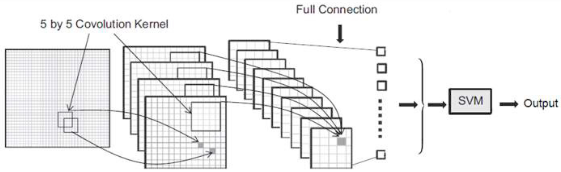

# Classification foliar diseases in apple trees

## Import Packages

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.metrics import Precision, Recall
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
import seaborn as sns
import cv2
import pathlib
import os

## Preprocessing Dataset Images

In [2]:
dataset_folder = os.path.join("/kaggle/input/plant-pathology-2020-fgvc7")

In [3]:
datasetObject = pd.read_csv(os.path.join(dataset_folder, "train.csv"))
datasetObject.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [4]:
imagesDataset = pathlib.Path(os.path.join(dataset_folder, "images"))
listImages = list(imagesDataset.glob("*.*"))

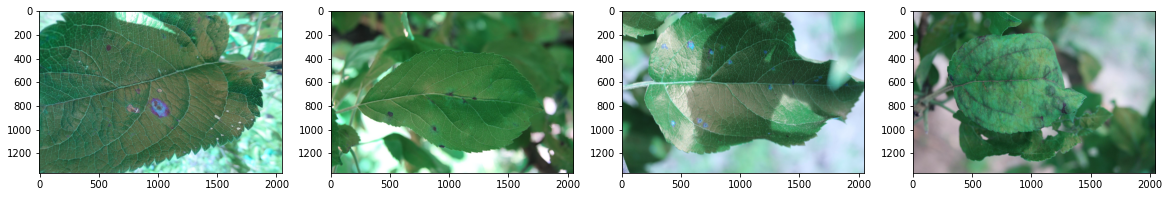

In [7]:
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = cv2.imread(str(listImages[i]))
    plt.imshow(img)
plt.show()

In [5]:
images_id_csv = datasetObject['image_id']
healthy_csv = datasetObject['healthy']
multiple_diseases_csv = datasetObject['multiple_diseases']
rust_csv = datasetObject['rust']
scab_csv = datasetObject['scab']

In [6]:
images = []
labels = []
for index, values in enumerate(images_id_csv):
    img = cv2.imread(os.path.join(dataset_folder, "images", "{}.jpg".format(values)))
    img = cv2.resize(img, (100, 100))
    img = img/255
    labels.append([healthy_csv[index], multiple_diseases_csv[index], rust_csv[index],
                 scab_csv[index]])
    images.append(img)

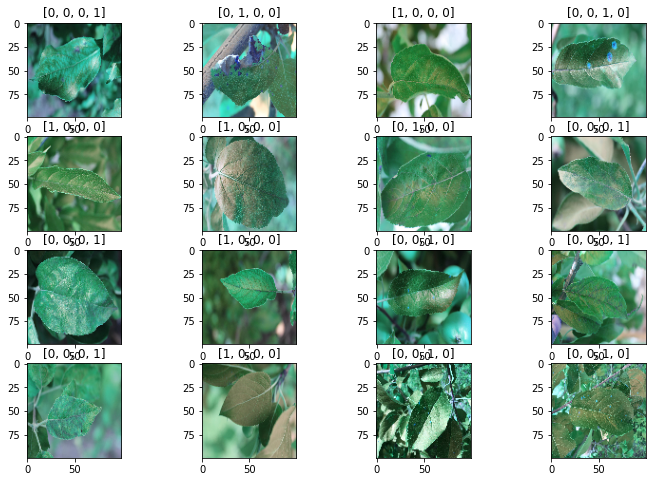

In [10]:
plt.figure(figsize = (12, 8))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()

In [7]:
img_data_g = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0.35,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        width_shift_range=0.15,
        height_shift_range=0.15,
        rescale=None)

## Images Data Augentation

In [8]:
images_after_aug = []
labels_after_aug = []
for index, image in enumerate(images):
  for i in range(9):
      img = img_data_g.flow(np.reshape(image, (1, 100, 100, 3))).next()
      images_after_aug.append(np.reshape(img, (100, 100, 3)))
      labels_after_aug.append(labels[index])
labels = np.asarray(labels_after_aug)
images = np.asarray(images_after_aug)

In [36]:
images.shape

(16389, 100, 100, 3)

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


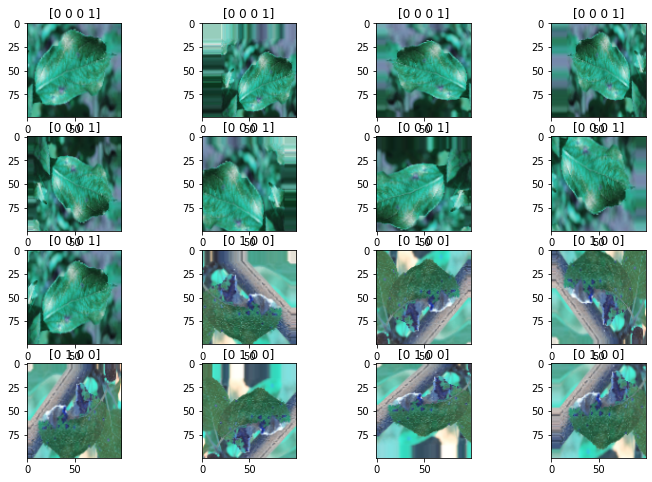

In [14]:
plt.figure(figsize = (12, 8))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()

## Build Model

In [9]:
d = tf.keras.applications.DenseNet121(include_top=False,
                   input_shape=(100,100,3),
                   pooling=None,
                   weights='imagenet')
for i in d.layers:
  i.trainable = True

2022-09-30 20:10:55.978951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 20:10:56.071446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 20:10:56.072342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 20:10:56.074177: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
output_avg = tf.keras.layers.GlobalAveragePooling2D()(d.output)
output_max = tf.keras.layers.GlobalMaxPooling2D()(d.output)
m = tf.keras.layers.minimum([output_avg, output_max])
m = tf.keras.layers.Dropout(0.5)(m)
m = tf.keras.layers.Dense(128, activation = "sigmoid")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(256, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(512, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(4, activation= "softmax")(m)
m = tf.keras.models.Model(inputs = d.input, outputs = m)
m.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
          loss = "categorical_crossentropy", 
          metrics =["accuracy", 
                     Precision(name='precision'), 
                     Recall(name='recall')])
m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.15, random_state = 42)

In [12]:
x_train.shape

(13930, 100, 100, 3)

In [13]:
x_test.shape

(2459, 100, 100, 3)

## Train Model

In [14]:
history = m.fit(x_train, y_train, epochs = 30, batch_size = 32,
                callbacks = [
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, mode = 'min',
                                                  patience= 1),
                    tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min', restore_best_weights = True)
                ])

2022-09-30 20:11:01.783333: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1671600000 exceeds 10% of free system memory.
2022-09-30 20:11:03.710051: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1671600000 exceeds 10% of free system memory.
2022-09-30 20:11:05.355706: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-09-30 20:11:17.307321: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


436/436 [==============================] - 53s 79ms/step - loss: 0.5739 - accuracy: 0.8025 - precision: 0.8579 - recall: 0.7515
Epoch 2/30
436/436 [==============================] - 33s 76ms/step - loss: 0.3518 - accuracy: 0.8950 - precision: 0.9170 - recall: 0.8753
Epoch 3/30
436/436 [==============================] - 33s 76ms/step - loss: 0.2785 - accuracy: 0.9126 - precision: 0.9321 - recall: 0.8956
Epoch 4/30
436/436 [==============================] - 33s 76ms/step - loss: 0.2380 - accuracy: 0.9265 - precision: 0.9405 - recall: 0.9116
Epoch 5/30
436/436 [==============================] - 33s 76ms/step - loss: 0.2122 - accuracy: 0.9311 - precision: 0.9430 - recall: 0.9220
Epoch 6/30
436/436 [==============================] - 33s 76ms/step - loss: 0.1904 - accuracy: 0.9409 - precision: 0.9507 - recall: 0.9307
Epoch 7/30
436/436 [==============================] - 34s 77ms/step - loss: 0.1621 - accuracy: 0.9457 - precision: 0.9524 - recall: 0.9391
Epoch 8/30
436/436 [==================

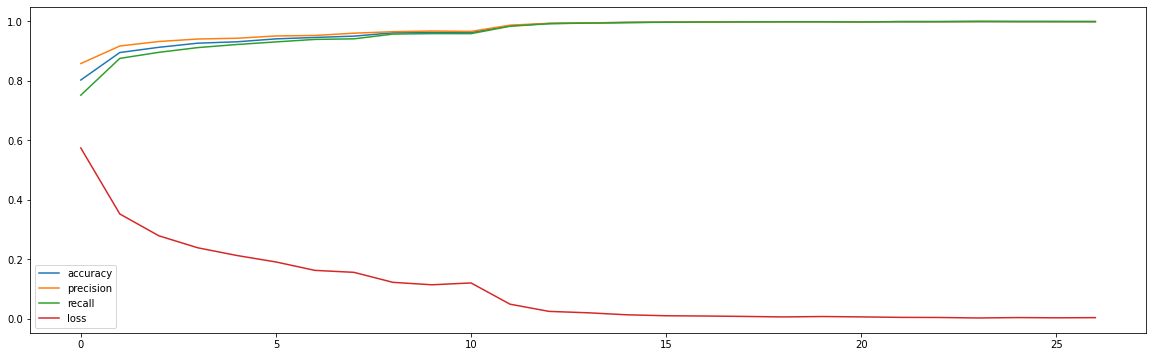

In [16]:
plt.figure(figsize = (20, 6))
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['precision'], label = "precision")
plt.plot(history.history['recall'], label = "recall")
plt.plot(history.history['loss'], label = "loss")
plt.legend()

In [17]:
m.evaluate(x_test, y_test, batch_size= 32)

77/77 [==============================] - 4s 31ms/step - loss: 0.0522 - accuracy: 0.9902 - precision: 0.9902 - recall: 0.9902


[0.05215660110116005,
 0.9902399182319641,
 0.9902399182319641,
 0.9902399182319641]

In [18]:
y_pred = m.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)

In [19]:
y_pred

array([3, 3, 2, ..., 2, 0, 0])

In [20]:
y_test = np.argmax(y_test, axis = 1)

In [21]:
cnn_standard_acc = accuracy_score(y_pred, y_test)
print(cnn_standard_acc)

0.9902399349328995


In [22]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       726
           1       0.91      0.94      0.93       105
           2       1.00      1.00      1.00       830
           3       0.99      0.98      0.99       798

    accuracy                           0.99      2459
   macro avg       0.97      0.98      0.98      2459
weighted avg       0.99      0.99      0.99      2459



In [23]:
def generate_confusion_matrix(y_pred, y_test):
    c = tf.math.confusion_matrix(y_pred, y_test)
    sns.heatmap(c, annot=True)

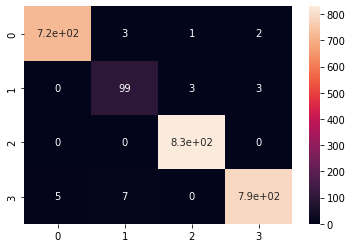

In [24]:
generate_confusion_matrix(y_pred, y_test)

# CNN Features + (RandomForest , XGBOOST, SVM)

## Extract CNN features from CMM pre_traind Model

In [26]:
new_model = tf.keras.models.Model(
    m.input, m.get_layer('minimum').output
)

In [27]:
features_x_train = new_model.predict(x_train)

2022-09-30 20:29:09.422633: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1671600000 exceeds 10% of free system memory.
2022-09-30 20:29:11.732082: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1671600000 exceeds 10% of free system memory.


In [28]:
features_x_test = new_model.predict(x_test)

In [29]:
features_x_train.shape

(13930, 1024)

## Features Engineering by scaling it

In [30]:
scaler = StandardScaler()
scaler.fit(features_x_train)

StandardScaler()

In [31]:
x_tr = scaler.transform(features_x_train)
x_te = scaler.transform(features_x_test)

## XGBClassifier

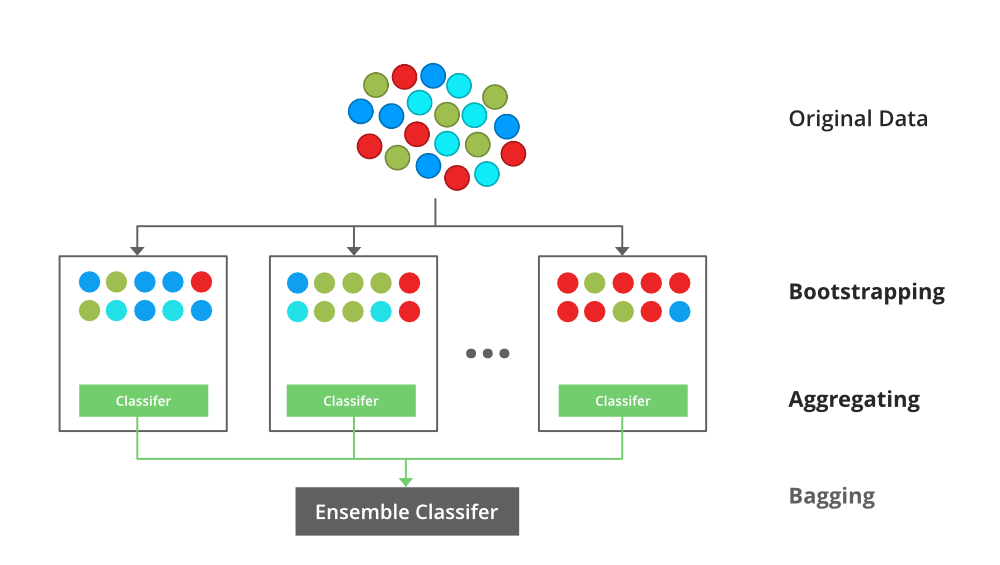

In [32]:
clf = xgb.XGBClassifier(max_depth = 50, n_estimators = 500)
clf.fit(x_tr, np.argmax(y_train, axis = 1))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=50, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [33]:
y_pred = clf.predict(x_te)

In [34]:
xgboost_acc = accuracy_score(y_pred, y_test)
print(xgboost_acc)

0.986173241154941


In [35]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       723
           1       0.87      0.91      0.89       104
           2       1.00      1.00      1.00       834
           3       0.99      0.98      0.99       798

    accuracy                           0.99      2459
   macro avg       0.96      0.97      0.97      2459
weighted avg       0.99      0.99      0.99      2459



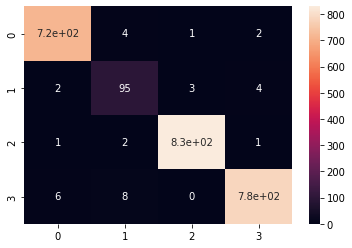

In [36]:
generate_confusion_matrix(y_pred, y_test)

## RandomForestClassifier

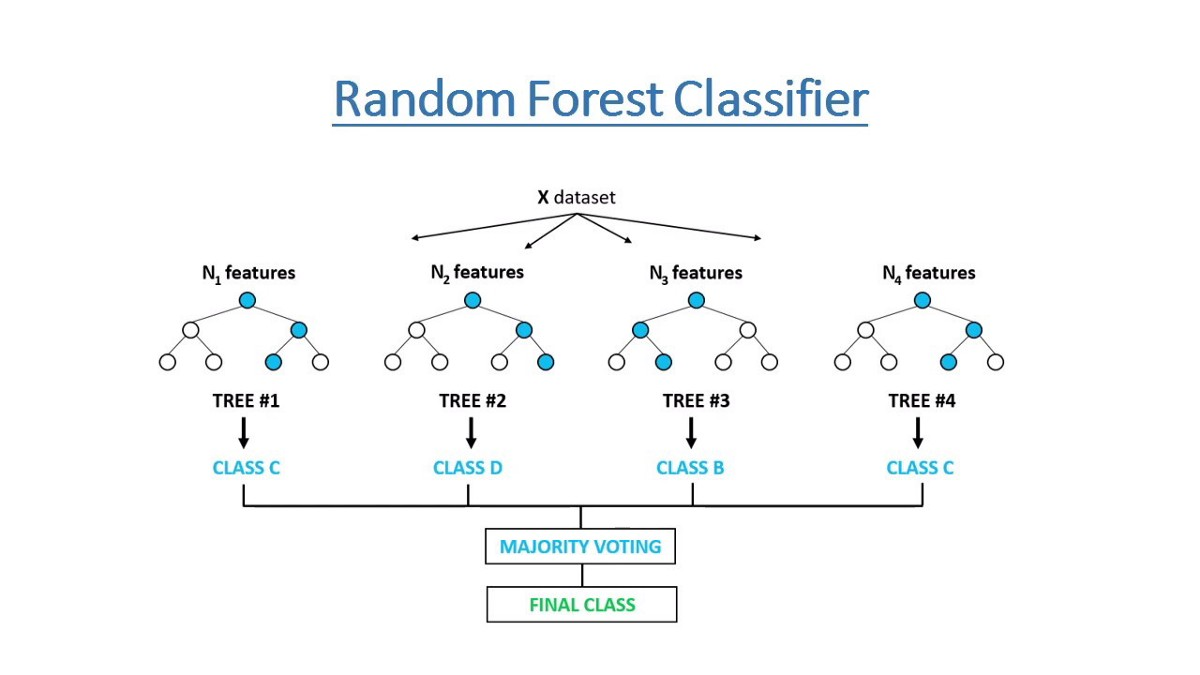

In [37]:
clf = RandomForestClassifier(max_depth=50,n_estimators = 500)
clf.fit(x_tr, np.argmax(y_train, axis = 1))
y_pred = clf.predict(x_te)

In [38]:
randomforest_acc = accuracy_score(y_pred, y_test)
print(randomforest_acc)

0.9873932492883286


In [39]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       721
           1       0.86      0.95      0.90        99
           2       1.00      1.00      1.00       832
           3       1.00      0.98      0.99       807

    accuracy                           0.99      2459
   macro avg       0.96      0.98      0.97      2459
weighted avg       0.99      0.99      0.99      2459



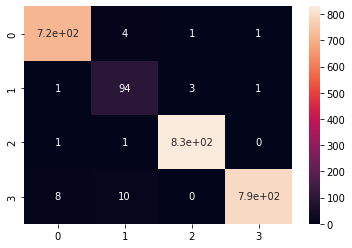

In [40]:
generate_confusion_matrix(y_pred, y_test)

## Support vector machines (SVMs)

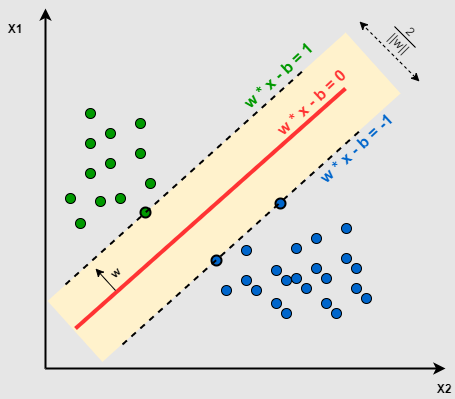

In [42]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(x_tr, np.argmax(y_train, axis = 1))
y_pred = clf.predict(x_te)

In [43]:
svm_acc = accuracy_score(y_pred, y_test)
print(svm_acc)

0.9886132574217161


In [44]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       722
           1       0.91      0.95      0.93       104
           2       0.99      1.00      1.00       830
           3       0.99      0.98      0.99       803

    accuracy                           0.99      2459
   macro avg       0.97      0.98      0.98      2459
weighted avg       0.99      0.99      0.99      2459



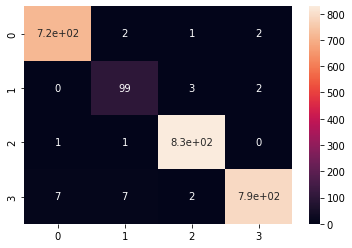

In [45]:
generate_confusion_matrix(y_pred, y_test)

# Final Results

In [48]:
pd.DataFrame({
    "Algorithm": ["DenseNet CNN", "CNN + XGBOOST", "CNN + Random Forest", "CNN + SVM"],
    "Accuracy for same testing data": [cnn_standard_acc, xgboost_acc, randomforest_acc, svm_acc],
}).head()

,Algorithm,Accuracy for same testing data
0,DenseNet CNN,0.990240
1,CNN + XGBOOST,0.986173
2,CNN + Random Forest,0.987393
3,CNN + SVM,0.988613


# Summary
According to the results obtained, neural networks are still able to give better accuracy than the rest of the proposed models.